In [4]:
# ==========================
# MiniViT Model Introspection
# ==========================
import torch
import numpy as np

def _count_params(module):
    total = sum(p.numel() for p in module.parameters())
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    return total, trainable

@torch.no_grad()
def print_minivit_details(model, img_size=256, patch_size=16, show_block_params=True, show_head_importance=False):
    device = next(model.parameters()).device
    embed_dim = model.pos_embed.shape[-1]
    depth = len(model.blocks)
    heads = model.blocks[0].attn.num_heads
    head_dim = model.blocks[0].attn.head_dim
    grid = img_size // patch_size
    n_patches = grid * grid
    n_tokens = n_patches + 1  # +CLS

    total, trainable = _count_params(model)

    # Header
    print("="*60)
    print("MiniViT Summary")
    print("-"*60)
    print(f"Image size        : {img_size} x {img_size}")
    print(f"Patch size        : {patch_size} (grid {grid} x {grid} => {n_patches} patches)")
    print(f"Tokens (incl CLS) : {n_tokens}")
    print(f"Embed dim         : {embed_dim}")
    print(f"Depth (blocks)    : {depth}")
    print(f"Heads / head_dim  : {heads} / {head_dim}")
    print(f"MLP ratio (blk0)  : {model.blocks[0].mlp.fc1.out_features / embed_dim:.2f}")
    print(f"PosEmbed shape    : {tuple(model.pos_embed.shape)}")
    print(f"Total params      : {total/1e6:.2f} M  (trainable: {trainable/1e6:.2f} M)")
    print("-"*60)

    # Block-wise quick view
    if show_block_params:
        print("Per-block details:")
        for i, blk in enumerate(model.blocks):
            qkv = blk.attn.qkv
            proj = blk.attn.proj
            fc1, fc2 = blk.mlp.fc1, blk.mlp.fc2
            dp = blk.drop_path.drop_prob if hasattr(blk.drop_path, "drop_prob") else 0.0

            qkv_params, _ = _count_params(qkv)
            proj_params, _ = _count_params(proj)
            mlp_params, _  = _count_params(blk.mlp)
            blk_params, _  = _count_params(blk)
            print(f" Block {i:02d}: heads={blk.attn.num_heads}, drop_path={dp:.3f}, "
                  f"qkv={qkv_params/1e6:.2f}M, proj={proj_params/1e6:.2f}M, "
                  f"mlp={mlp_params/1e6:.2f}M, total={blk_params/1e6:.2f}M")

    # Dummy forward to report tensor shapes & attention shapes
    x = torch.zeros(1, 3, img_size, img_size, device=device)
    logits, attns = model(x, return_attn=True)  # attns: list of (B,H,N,N)
    print("-"*60)
    print(f"Forward check: logits shape = {tuple(logits.shape)}")
    if attns and len(attns) == depth:
        a0 = attns[0]
        print(f"Attention shape (per block): (B={a0.shape[0]}, H={a0.shape[1]}, N={a0.shape[2]}, N={a0.shape[3]})")
        print(f"Expected N = {n_tokens} (matches: {a0.shape[-1]==n_tokens})")

    # Optional: simple weight-based head-importance (L2 of Q,K,V,Proj slices)
    if show_head_importance:
        print("-"*60)
        print("Head importance (normalized L2 weight norms) — per block:")
        for bi, blk in enumerate(model.blocks):
            attn = blk.attn
            H, D = attn.num_heads, attn.head_dim
            dim = H * D
            Wqkv = attn.qkv.weight.detach().cpu().view(3, dim, -1).reshape(3, H, D, -1)
            Wproj = attn.proj.weight.detach().cpu().view(H, D, -1)
            scores = []
            for h in range(H):
                n = (Wqkv[0,h].norm(p=2) + Wqkv[1,h].norm(p=2) + Wqkv[2,h].norm(p=2) + Wproj[h].norm(p=2)).item()
                scores.append(n)
            scores = np.array(scores, dtype=np.float32)
            s = (scores / (scores.max() + 1e-8)).round(3)
            weak_idx = int(s.argmin())
            print(f" Block {bi:02d}: heads={H}, norms={s.tolist()}  (weakest head idx={weak_idx})")

    print("="*60)

# ---- Usage examples ----
# If you've already got a trained model loaded as `model`, do:
print_minivit_details(model, img_size=CFG["IMG_SIZE"], patch_size=CFG["PATCH_SIZE"],
                      show_block_params=True, show_head_importance=False)

# If you want to also see head-importance:
# print_minivit_details(model, img_size=CFG["IMG_SIZE"], patch_size=CFG["PATCH_SIZE"],
#                       show_block_params=True, show_head_importance=True)

MiniViT Summary
------------------------------------------------------------
Image size        : 256 x 256
Patch size        : 16 (grid 16 x 16 => 256 patches)
Tokens (incl CLS) : 257
Embed dim         : 256
Depth (blocks)    : 6
Heads / head_dim  : 4 / 64
MLP ratio (blk0)  : 4.00
PosEmbed shape    : (1, 257, 256)
Total params      : 5.00 M  (trainable: 5.00 M)
------------------------------------------------------------
Per-block details:
 Block 00: heads=4, drop_path=0.000, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 01: heads=4, drop_path=0.020, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 02: heads=4, drop_path=0.040, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 03: heads=4, drop_path=0.060, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 04: heads=4, drop_path=0.080, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 05: heads=4, drop_path=0.100, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
----------------------------------------------------------

In [5]:
print_minivit_details(model, img_size=CFG["IMG_SIZE"], patch_size=CFG["PATCH_SIZE"],
                      show_block_params=True, show_head_importance=True)

MiniViT Summary
------------------------------------------------------------
Image size        : 256 x 256
Patch size        : 16 (grid 16 x 16 => 256 patches)
Tokens (incl CLS) : 257
Embed dim         : 256
Depth (blocks)    : 6
Heads / head_dim  : 4 / 64
MLP ratio (blk0)  : 4.00
PosEmbed shape    : (1, 257, 256)
Total params      : 5.00 M  (trainable: 5.00 M)
------------------------------------------------------------
Per-block details:
 Block 00: heads=4, drop_path=0.000, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 01: heads=4, drop_path=0.020, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 02: heads=4, drop_path=0.040, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 03: heads=4, drop_path=0.060, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 04: heads=4, drop_path=0.080, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
 Block 05: heads=4, drop_path=0.100, qkv=0.20M, proj=0.07M, mlp=0.53M, total=0.79M
----------------------------------------------------------

Train/Val/Test: 72657 10379 20761
Train label counts: Counter({1: 55157, 0: 17500})


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/10 | train 0.0468 | val 0.0343


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/10 | train 0.0294 | val 0.0222


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/10 | train 0.0237 | val 0.0191


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/10 | train 0.0207 | val 0.0137


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/10 | train 0.0193 | val 0.0113


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 6/10 | train 0.0171 | val 0.0122


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 7/10 | train 0.0159 | val 0.0172


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 8/10 | train 0.0145 | val 0.0127


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 9/10 | train 0.0118 | val 0.0159


  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Epoch 10/10 | train 0.0097 | val 0.0193

[min-ACER op]  AUC=0.9941 | thr=0.523 | APCER=4.00% | BPCER=3.80% | ACER=3.90%
[BPCER<=5%]   thr=0.477 | APCER=2.72% | BPCER=4.98% | ACER=3.85%

Per-attack APCER (min-ACER op):
   iPad_ReplayAttack: 10.10%  (505/5000)
 Webcam_ReplayAttack: 0.48%  (24/5001)
Samsung_ReplayAttack: 1.36%  (68/5000)
         PrintAttack: 4.34%  (33/760)


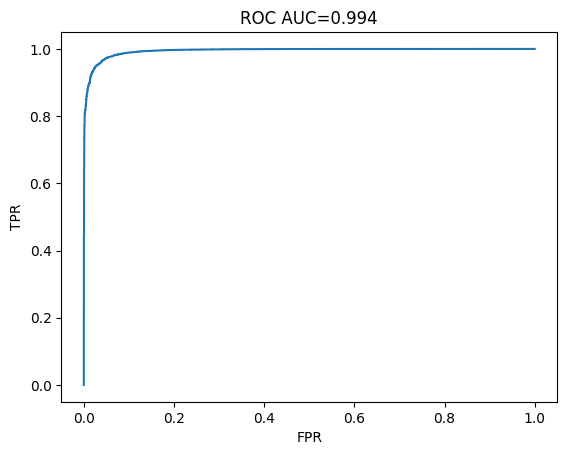

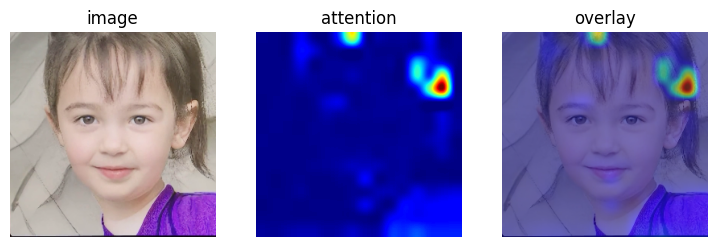

In [6]:
# ---- Config -----------------------------------------------------------------
import os, io, math, random, numpy as np, torch
from pathlib import Path
from glob import glob
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CFG = {
    # Paths (as you provided)
    "ROOT": "/kaggle/input/synthaspoof/SynthASpoof",
    "BONA": "BonaFide",
    "PAs": {
        "PrintAttack": "PAs/PrintAttack",
        "Samsung_ReplayAttack": "PAs/Samsung_ReplayAttack",
        "Webcam_ReplayAttack":  "PAs/Webcam_ReplayAttack",
        "iPad_ReplayAttack":    "PAs/iPad_ReplayAttack",
    },

    # Image/model settings
    "IMG_SIZE": 256,       # train & eval at same size (matches your best)
    "PATCH_SIZE": 16,      # set 8 if training at 160 for more detail
    "EMBED_DIM": 256,
    "DEPTH": 6,
    "NUM_HEADS": 4,
    "MLP_RATIO": 4.0,

    # Training
    "EPOCHS": 10,
    "BATCH_SIZE": 64,
    "NUM_WORKERS": 2,
    "LR": 2e-4,
    "WEIGHT_DECAY": 1e-4,
    "SEED": 42,
    "TRAIN_RATIO": 0.7,
    "VAL_RATIO": 0.1,      # test = 1 - train - val
    "USE_ATTACK_SAMPLER": True,   # oversample hard attacks (iPad/Print)
    "USE_FOCAL": True,

    # Checkpoint
    "CKPT_PATH": "/kaggle/working/minivit_best.pth",
}

# ---- Repro ------------------------------------------------------------------
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(CFG["SEED"])

# ---- Data indexing & split ---------------------------------------------------
from PIL import Image, ImageFile, ImageFilter
ImageFile.LOAD_TRUNCATED_IMAGES = True

def list_images(folder):
    exts = (".jpg",".jpeg",".png",".bmp",".webp")
    return [p for p in glob(str(Path(folder) / "**" / "*"), recursive=True) if p.lower().endswith(exts)]

def index_dataset():
    root = Path(CFG["ROOT"])
    items = []  # (path, label, attack_type)
    # bona fide
    for p in list_images(root / CFG["BONA"]):
        items.append((p, 0, "bonafide"))
    # attacks
    for atk_name, rel in CFG["PAs"].items():
        for p in list_images(root / rel):
            items.append((p, 1, atk_name))
    if not items:
        raise RuntimeError("No images found; check folder paths.")
    return items

def stratified_by_attack(items, train_ratio=0.7, val_ratio=0.1, seed=42):
    import pandas as pd
    from sklearn.model_selection import train_test_split
    df = pd.DataFrame(items, columns=["path","label","attack_type"])
    df["strata"] = df["label"].astype(str) + "_" + df["attack_type"]
    tr, tmp = train_test_split(df, test_size=(1-train_ratio), stratify=df["strata"], random_state=seed)
    tmp["strata"] = tmp["label"].astype(str) + "_" + tmp["attack_type"]
    val_size = val_ratio / (1 - train_ratio)
    va, te = train_test_split(tmp, test_size=(1 - val_size), stratify=tmp["strata"], random_state=seed)
    to_list = lambda d: list(zip(d["path"].tolist(), d["label"].tolist(), d["attack_type"].tolist()))
    return to_list(tr), to_list(va), to_list(te)

# ---- Dataset & targeted augmentations ---------------------------------------
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class ReplayAug:
    """Simulate replay artifacts (down/up-scale, JPEG, blur)."""
    def __init__(self, scale=(0.6,1.0), jpeg_q=(30,80), blur_p=0.5):
        self.scale, self.jpeg_q, self.blur_p = scale, jpeg_q, blur_p
    def __call__(self, img):
        w,h = img.size
        s = random.uniform(*self.scale)
        img = img.resize((max(8,int(w*s)), max(8,int(h*s))), Image.BICUBIC).resize((w,h), Image.BICUBIC)
        if random.random() < self.blur_p:
            img = img.filter(ImageFilter.GaussianBlur(random.uniform(0.2,1.0)))
        buf = io.BytesIO(); img.save(buf, format="JPEG", quality=random.randint(*self.jpeg_q)); buf.seek(0)
        return Image.open(buf).convert("RGB")

class PrintAug:
    """Simulate print recapture artifacts (resample + JPEG)."""
    def __init__(self, scale=(0.7,1.0), jpeg_q=(40,85)):
        self.scale, self.jpeg_q = scale, jpeg_q
    def __call__(self, img):
        w,h = img.size
        s = random.uniform(*self.scale)
        img = img.resize((max(8,int(w*s)), max(8,int(h*s))), Image.BICUBIC).resize((w,h), Image.BICUBIC)
        buf = io.BytesIO(); img.save(buf, format="JPEG", quality=random.randint(*self.jpeg_q)); buf.seek(0)
        return Image.open(buf).convert("RGB")

class PADTrainDataset(Dataset):
    def __init__(self, items, image_size=256):
        self.items = items
        self.replay_aug = ReplayAug()
        self.print_aug  = PrintAug()
        self.tf = T.Compose([
            T.Resize(int(image_size*1.15)),
            T.RandomResizedCrop(image_size, scale=(0.8,1.0)),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3),
        ])
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, label, atk = self.items[i]
        img = Image.open(path).convert("RGB")
        # attack-targeted aug
        if label == 1:
            if "PrintAttack" in atk: img = self.print_aug(img)
            else:                    img = self.replay_aug(img)
        x = self.tf(img)
        y = torch.tensor(label, dtype=torch.float32)
        return x, y, atk

class PADEvalDataset(Dataset):
    def __init__(self, items, image_size=256):
        self.items = items
        self.tf = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize([0.5]*3, [0.5]*3),
        ])
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        path, label, atk = self.items[i]
        x = self.tf(Image.open(path).convert("RGB"))
        y = torch.tensor(label, dtype=torch.float32)
        return x, y, atk

def make_attack_balanced_sampler(train_items):
    # inverse-frequency per attack_type (bonafide is its own type)
    types = [atk for _,_,atk in train_items]
    cnt = Counter(types)
    inv = {k: 1.0/max(v,1) for k,v in cnt.items()}
    weights = np.array([inv[atk] for _,_,atk in train_items], dtype=np.float32)
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# ---- MiniViT (custom) -------------------------------------------------------
import torch.nn as nn
import torch.nn.functional as F

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0): super().__init__(); self.drop_prob=drop_prob
    def forward(self, x):
        if self.drop_prob==0.0 or not self.training: return x
        keep = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,)*(x.ndim-1)
        mask = x.new_empty(shape).bernoulli_(keep).div_(keep)
        return x * mask

class PatchEmbed(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=3, embed_dim=256):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.grid  = img_size // patch_size
    def forward(self, x):
        x = self.proj(x)             # (B,C,H/ps,W/ps)
        x = x.flatten(2).transpose(1,2)  # (B,N,C)
        return x

class MLP(nn.Module):
    def __init__(self, dim, hidden, drop=0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden); self.act = nn.GELU(); self.drop = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden, dim)
    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, heads=4, qkv_bias=True, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % heads == 0
        self.num_heads = heads; self.head_dim = dim // heads; self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim); self.proj_drop = nn.Dropout(proj_drop)
        self.register_buffer("head_mask", torch.ones(heads), persistent=False)
        self._last_attn = None
    def forward(self, x):
        B,N,C = x.shape
        qkv = self.qkv(x).reshape(B,N,3,self.num_heads,self.head_dim).permute(2,0,3,1,4)
        q,k,v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2,-1)) * self.scale
        attn = attn.softmax(dim=-1)
        self._last_attn = attn.detach()
        attn = self.attn_drop(attn)
        hm = self.head_mask.view(1,-1,1,1)
        x = (attn*hm) @ v
        x = x.transpose(1,2).reshape(B,N,C)
        x = self.proj(x); x = self.proj_drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4.0, drop=0.0, attn_drop=0.0, drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = Attention(dim, heads, qkv_bias=True, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path>0 else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, int(dim*mlp_ratio), drop=drop)
    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class MiniViT(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=3,
                 num_classes=1, embed_dim=256, depth=6, heads=4,
                 mlp_ratio=4.0, drop=0.0, attn_drop=0.0, drop_path=0.1):
        super().__init__()
        self.patch = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        n_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1+n_patches, embed_dim))
        self.pos_drop  = nn.Dropout(drop)
        dpr = [x.item() for x in torch.linspace(0, drop_path, depth)]
        self.blocks = nn.ModuleList([Block(embed_dim, heads, mlp_ratio, drop, attn_drop, dpr[i]) for i in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        self._init_weights()
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02); nn.init.constant_(self.head.bias, 0)
    @torch.no_grad()
    def set_head_mask(self, layer_idx, mask_1d):
        self.blocks[layer_idx].attn.head_mask.copy_(mask_1d.float().to(self.pos_embed.device))
    def forward(self, x, return_attn=False):
        B = x.size(0)
        x = self.patch(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1) + self.pos_embed
        x = self.pos_drop(x)
        attn_maps = []
        for blk in self.blocks:
            x = blk(x)
            if return_attn: attn_maps.append(blk.attn._last_attn)
        x = self.norm(x); cls_out = x[:,0]
        logit = self.head(cls_out).squeeze(-1)
        return (logit, attn_maps) if return_attn else logit

# ---- Loss, metrics, helpers --------------------------------------------------
def focal_loss(logits, targets, alpha=0.35, gamma=2.0):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    p = torch.sigmoid(logits); pt = p*targets + (1-p)*(1-targets)
    w = alpha*targets + (1-alpha)*(1-targets)
    return (w * (1-pt).pow(gamma) * bce).mean()

def pick_threshold_min_acer(y, p):
    ts = np.linspace(0,1,2001); best_t, best_a = 0.5, 1.0
    for t in ts:
        pred = (p>=t).astype(int)
        ap = ((y==1)&(pred==0)).sum()/max((y==1).sum(),1)
        bp = ((y==0)&(pred==1)).sum()/max((y==0).sum(),1)
        ac = (ap+bp)/2
        if ac < best_a: best_a, best_t = ac, t
    return best_t, best_a

def threshold_at_bpcer(y, p, target_bpcer=0.05):
    ts = np.linspace(0,1,2001); best_t=0.5; best_ap=1.0
    for t in ts:
        pred = (p>=t).astype(int)
        bp = ((y==0)&(pred==1)).sum()/max((y==0).sum(),1)
        if bp <= target_bpcer:
            ap = ((y==1)&(pred==0)).sum()/max((y==1).sum(),1)
            if ap < best_ap: best_ap, best_t = ap, t
    return best_t

# ---- Build splits & loaders --------------------------------------------------
items = index_dataset()
train_items, val_items, test_items = stratified_by_attack(items, CFG["TRAIN_RATIO"], CFG["VAL_RATIO"], CFG["SEED"])

print("Train/Val/Test:", len(train_items), len(val_items), len(test_items))
print("Train label counts:", Counter([lbl for _,lbl,_ in train_items]))

train_ds = PADTrainDataset(train_items, image_size=CFG["IMG_SIZE"])
val_ds   = PADEvalDataset(val_items,   image_size=CFG["IMG_SIZE"])
test_ds  = PADEvalDataset(test_items,  image_size=CFG["IMG_SIZE"])

if CFG["USE_ATTACK_SAMPLER"]:
    sampler = make_attack_balanced_sampler(train_items)
    train_loader = DataLoader(train_ds, batch_size=CFG["BATCH_SIZE"], sampler=sampler,
                              num_workers=CFG["NUM_WORKERS"], pin_memory=True)
else:
    train_loader = DataLoader(train_ds, batch_size=CFG["BATCH_SIZE"], shuffle=True,
                              num_workers=CFG["NUM_WORKERS"], pin_memory=True)

val_loader  = DataLoader(val_ds,  batch_size=CFG["BATCH_SIZE"], shuffle=False,
                         num_workers=CFG["NUM_WORKERS"], pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                         num_workers=CFG["NUM_WORKERS"], pin_memory=True)

# ---- Train -------------------------------------------------------------------
from torch.optim import AdamW
from tqdm.auto import tqdm
model = MiniViT(img_size=CFG["IMG_SIZE"], patch_size=CFG["PATCH_SIZE"], embed_dim=CFG["EMBED_DIM"],
                depth=CFG["DEPTH"], heads=CFG["NUM_HEADS"], mlp_ratio=CFG["MLP_RATIO"]).to(DEVICE)
opt = AdamW(model.parameters(), lr=CFG["LR"], weight_decay=CFG["WEIGHT_DECAY"])

def run_epoch(loader, train=True):
    model.train(train)
    tot, ys, ps = 0.0, [], []
    for xb, yb, _ in tqdm(loader, leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        loss = focal_loss(out, yb) if CFG["USE_FOCAL"] else F.binary_cross_entropy_with_logits(out, yb)
        if train:
            opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        tot += loss.item() * xb.size(0)
        ys.append(yb.detach().cpu()); ps.append(torch.sigmoid(out).detach().cpu())
    ys = torch.cat(ys).numpy(); ps = torch.cat(ps).numpy()
    return tot/len(loader.dataset), ys, ps

best_val = 1e9
for ep in range(CFG["EPOCHS"]):
    tr_loss, ytr, ptr = run_epoch(train_loader, True)
    va_loss, yva, pva = run_epoch(val_loader, False)
    print(f"Epoch {ep+1}/{CFG['EPOCHS']} | train {tr_loss:.4f} | val {va_loss:.4f}")
    if va_loss < best_val:
        best_val = va_loss
        torch.save({"state_dict": model.state_dict(), "config": {**CFG}}, CFG["CKPT_PATH"])

# ---- Load best (safe for future size changes) --------------------------------
def load_minivit_flex(ckpt_path, target_img_size=CFG["IMG_SIZE"]):
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    state = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
    model2 = MiniViT(img_size=target_img_size, patch_size=CFG["PATCH_SIZE"], embed_dim=CFG["EMBED_DIM"],
                     depth=CFG["DEPTH"], heads=CFG["NUM_HEADS"], mlp_ratio=CFG["MLP_RATIO"]).to(DEVICE)
    # interpolate pos_embed if needed
    if "pos_embed" in state and state["pos_embed"].shape != model2.pos_embed.shape:
        pe = state["pos_embed"]; cls, patch = pe[:, :1, :], pe[:, 1:, :]
        n_old = patch.shape[1]; gs_old = int(math.sqrt(n_old))
        n_new = model2.pos_embed.shape[1] - 1; gs_new = int(math.sqrt(n_new))
        patch = patch.transpose(1,2).reshape(1, pe.size(-1), gs_old, gs_old)
        patch = F.interpolate(patch, size=(gs_new, gs_new), mode="bicubic", align_corners=False)
        patch = patch.flatten(2).transpose(1,2)
        state["pos_embed"] = torch.cat([cls, patch], dim=1)
        model2.load_state_dict(state, strict=False)
    else:
        model2.load_state_dict(state, strict=True)
    model2.eval()
    return model2

model = load_minivit_flex(CFG["CKPT_PATH"], CFG["IMG_SIZE"])

# ---- Evaluate (ISO terms) ----------------------------------------------------
from sklearn.metrics import roc_auc_score, roc_curve

@torch.no_grad()
def collect(loader):
    ys, ps, atks = [], [], []
    for xb, yb, atk in loader:
        pr = torch.sigmoid(model(xb.to(DEVICE))).cpu().numpy()
        ys.append(yb.numpy()); ps.append(pr); atks += list(atk)
    return np.concatenate(ys), np.concatenate(ps), atks

# threshold by min-ACER (val), report on test
y_val, p_val, _ = collect(val_loader)
thr_min, acer_val = pick_threshold_min_acer(y_val, p_val)

y_te, p_te, atks_te = collect(test_loader)
auc = roc_auc_score(y_te, p_te)
pred = (p_te >= thr_min).astype(int)
apcer = ((y_te==1)&(pred==0)).sum()/max((y_te==1).sum(),1)
bpcer = ((y_te==0)&(pred==1)).sum()/max((y_te==0).sum(),1) if (y_te==0).sum()>0 else 0.0
acer  = (apcer + bpcer)/2
print(f"\n[min-ACER op]  AUC={auc:.4f} | thr={thr_min:.3f} | APCER={apcer:.2%} | BPCER={bpcer:.2%} | ACER={acer:.2%}")

# also report at fixed BPCER = 5% (prod-style)
thr_bpc = threshold_at_bpcer(y_val, p_val, target_bpcer=0.05)
pred_b = (p_te >= thr_bpc).astype(int)
bpcer_b = ((y_te==0)&(pred_b==1)).sum()/max((y_te==0).sum(),1)
apcer_b = ((y_te==1)&(pred_b==0)).sum()/max((y_te==1).sum(),1)
print(f"[BPCER<=5%]   thr={thr_bpc:.3f} | APCER={apcer_b:.2%} | BPCER={bpcer_b:.2%} | ACER={((apcer_b+bpcer_b)/2):.2%}")

# per-attack APCER (min-ACER op)
tab = defaultdict(lambda: [0,0])
for yi, pi, ai in zip(y_te, pred, atks_te):
    if yi==1:
        tab[ai][1]+=1
        if pi==0: tab[ai][0]+=1
print("\nPer-attack APCER (min-ACER op):")
for k,(e,t) in tab.items():
    r = (e/t) if t>0 else 0.0
    print(f"{k:>20s}: {r:.2%}  ({e}/{t})")

# ROC (classic FPR/TPR)
fpr, tpr, _ = roc_curve(y_te, p_te)
plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC AUC={auc:.3f}"); plt.show()

# ---- Attention rollout heatmap on one test sample ---------------------------
import torchvision.transforms.functional as TF

def vit_rollout(model, img_pil, img_size=CFG["IMG_SIZE"]):
    # forward returning attns
    x = TF.resize(img_pil, (img_size,img_size))
    x = TF.to_tensor(x); x = TF.normalize(x, [0.5]*3, [0.5]*3)[None].to(DEVICE)
    with torch.no_grad():
        _, attns = model(x, return_attn=True)  # list of (B,H,N,N)
    N = attns[0].shape[-1]
    eye = torch.eye(N, device=attns[0].device)
    roll = eye
    for A in attns:
        A = A.mean(dim=1)[0]
        A = A / A.sum(dim=-1, keepdim=True)
        A = (A + eye)/2
        roll = roll @ A
    cls = roll[0,1:]  # to patches
    S = int(math.sqrt(cls.numel()))
    m = cls.view(S,S).detach().cpu().numpy()
    m = (m - m.min())/(m.max()-m.min()+1e-6)
    m = np.array(Image.fromarray((m*255).astype(np.uint8)).resize((CFG["IMG_SIZE"], CFG["IMG_SIZE"])))
    return m

# pick one test image
sample_path = test_items[0][0]
img0 = Image.open(sample_path).convert("RGB").resize((CFG["IMG_SIZE"], CFG["IMG_SIZE"]))
hm = vit_rollout(model, img0)

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(img0); plt.axis('off'); plt.title("image")
plt.subplot(1,3,2); plt.imshow(hm, cmap='jet'); plt.axis('off'); plt.title("attention")
# overlay
hm_rgb = plt.get_cmap('jet')(hm/255.0)[...,:3]
overlay = (0.5*np.asarray(img0)/255.0 + 0.5*hm_rgb).clip(0,1)
plt.subplot(1,3,3); plt.imshow(overlay); plt.axis('off'); plt.title("overlay")
plt.show()